In [4]:
#-*-coding:utf-8-*-
from GameEnv import Game2048
from DQN import DQN
import random
import copy

def check_one_game(gameEnv,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = random.choice(["a","w","d","s"])
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

gameEnv = Game2048()
gameEnv.grid_n = 2

In [3]:
import numpy as np
scores = []
n = 1000
for i in range(n):
    scores.append(check_one_game(gameEnv,False))
print np.average(scores)
print np.max(scores)
print np.min(scores)
# print np.sort(scores)

24.316
124
0


In [4]:
check_one_game(gameEnv,True)

-	 2	 

-	 2	 

_________________________________________
-	 2	 

-	 2	 

_________________________________________
2	 4	 

2	 -	 

_________________________________________
2	 4	 

4	 2	 

('this_score_____________________:', 0)


0

In [5]:
# 策略评估
import itertools
import numpy as np
def move(mtr, dirct):
    grid_n = 2
    score = 0
    visit = []
    if dirct == 0:  # left
        for i in range(grid_n):
            for j in range(1, grid_n):
                for k in range(j, 0, -1):
                    if mtr[i][k - 1] == 0:
                        mtr[i][k - 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k - 1] == mtr[i][k] and grid_n * i + k - 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k - 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k - 1]
                        visit.append(grid_n * i + k)
                        visit.append(grid_n * i + k - 1)
                        # for i in range(4):
                        #    for j in range(3):

    elif dirct == 1:  # down
        for j in range(grid_n):
            for i in range(grid_n-1, 0, -1):
                for k in range(0, i):
                    if mtr[k + 1][j] == 0:
                        mtr[k + 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k + 1][j] == mtr[k][j] and (grid_n * (k + 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k + 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k + 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k + 1) + j)


    elif dirct == 2:  # up
        for j in range(grid_n):
            for i in range(1, grid_n):
                for k in range(i, 0, -1):
                    if mtr[k - 1][j] == 0:
                        mtr[k - 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k - 1][j] == mtr[k][j] and (grid_n * (k - 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k - 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k - 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k - 1) + j)

    elif dirct == 3:  # right
        for i in range(grid_n):
            for j in range(grid_n-1, 0, -1):
                for k in range(j):
                    if mtr[i][k + 1] == 0:
                        mtr[i][k + 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k] == mtr[i][k + 1] and grid_n * i + k + 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k + 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k + 1]
                        visit.append(grid_n * i + k + 1)
                        visit.append(grid_n * i + k)

    return score

def test_step(matrix,action):
    if action == "a":
            dirct = 0
    elif action == "s":
        dirct = 1
    elif action == "w":
        dirct = 2
    elif action == "d":
        dirct = 3
            
    tmp = copy.deepcopy(matrix)
    score = move(matrix,dirct)
    res_list = []
    if tmp == matrix:
        return [tmp],0
    for i in range(2):
        for j in range(2):
            if matrix[i][j] == 0:
                copy_matrix_2 = copy.deepcopy(matrix)
                copy_matrix_4 = copy.deepcopy(matrix)
                copy_matrix_2[i][j] = 2
                copy_matrix_4[i][j] = 4
                res_list.append(copy_matrix_2)
                res_list.append(copy_matrix_4)
    return res_list,score
        

def policy_evaluate(hold=0.001,value_dict=None,policy = ["a","s","w","d"],debug=False):
    if value_dict is None:
        # 初始化所有状态，包含了部分不存在的状态
        v_dict = {}
        for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
            v_dict[str(s)] = 0
    else:
        print "use old"
        v_dict = value_dict
    s_list = v_dict.keys()
    
    # 循环，没有模拟随机产出这个步骤
    while True:
        delta = 0
        for s in s_list:
            v = v_dict[s]      # v ← V（s）
            vs = 0
            action_list = ["a","s","w","d"] if policy == ["a","s","w","d"] else policy[s]
            for action in action_list:                
                gameEnv.matrix = np.array(eval(s)).reshape(2,2).tolist()
                observation_next_list, reward = test_step(gameEnv.matrix,action)
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) not in v_dict:
                        continue
                    vs += (1.0 / len(action_list)) * (1.0 / len(observation_next_list)) * (reward + v_dict[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])              
                    # V(s) ← Σa π（a|s） Σp(s'|s,a)[r + γV（s'）]  

            v_dict[s] = vs
            delta = max(delta,abs(v - vs)) # Δ ← max(Δ，|v - V（s）|)
        if debug:print delta,v_dict[str((2,2,0,0))]
        if delta < hold:
            break
    return v_dict

# 策略评估

In [6]:
res = policy_evaluate(hold=0.1,value_dict=None,policy=['a','s','w','d'],debug=True)

32.625 3.3397386339
15.661026001 6.71784673914
8.59219646454 9.5432929482
6.79244828224 11.98500024
5.07918613404 14.1617584114
3.84754662588 16.0885733806
2.76740767434 17.7540123185
1.92427161708 19.158076557
1.61319551591 20.3176143234
1.38146299292 21.2603832664
1.16098734458 22.0181966653
0.960974946703 22.6222443509
0.787316551565 23.1006643787
0.644254917191 23.4776514405
0.522522468899 23.7734197586
0.420567920573 24.0045616728
0.336261952235 24.1845426765
0.267280335376 24.3242050401
0.211336579227 24.4322261805
0.166311432477 24.5155150195
0.130314985319 24.5795460751
0.101706760725 24.6286372428
0.0790910273006 24.6661788274


In [7]:
res

{'(8, 8, 2, 16)': 36.26925619099556,
 '(0, 8, 2, 0)': 15.294825460930756,
 '(16, 8, 8, 16)': 0.0,
 '(2, 16, 0, 4)': 6.6383409953544685,
 '(4, 16, 8, 2)': 0.0,
 '(32, 4, 4, 2)': 0.0,
 '(16, 8, 8, 32)': 0.0,
 '(8, 8, 2, 4)': 22.649864821277053,
 '(0, 2, 16, 0)': 10.605344398215069,
 '(32, 4, 2, 8)': 0.0,
 '(2, 2, 2, 16)': 13.711804259544502,
 '(16, 32, 0, 16)': 0.0,
 '(0, 8, 32, 4)': 8.49974288418889,
 '(0, 8, 16, 32)': 0.0,
 '(8, 0, 16, 2)': 4.034978629918533,
 '(8, 4, 0, 32)': 8.49974288418889,
 '(2, 32, 4, 8)': 0.0,
 '(32, 4, 0, 0)': 9.021106187212926,
 '(0, 4, 4, 0)': 21.45300625228097,
 '(32, 16, 16, 0)': 0.0,
 '(2, 0, 16, 8)': 4.285349450563636,
 '(32, 8, 4, 16)': 0.0,
 '(2, 8, 2, 2)': 19.3472977997273,
 '(16, 16, 2, 32)': 0.0,
 '(2, 16, 16, 2)': 0.0,
 '(32, 4, 8, 16)': 0.0,
 '(0, 16, 4, 4)': 11.224478490604632,
 '(2, 8, 4, 4)': 20.723539072714516,
 '(8, 8, 0, 4)': 17.462024710745123,
 '(2, 16, 0, 32)': 1.9999791979789734,
 '(0, 32, 4, 2)': 9.23348148423247,
 '(16, 2, 8, 2)': 16.14

In [8]:
status = str((2,2,0,0))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i])

2	 2	 

-	 -	 

a 21.648567798702555
s 22.673426837490965
w 24.666178827417887
d 21.762225032573408


In [9]:
status = str((4,4,0,2))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i]),statis_dict[i]

4	 4	 

-	 2	 

a 15.195165982779198 [18.936221784107413, 10.119223215933353, 16.752499981465395, 14.97271894961063]
s 8.903070944298854 [0.0, 17.806141888597708]
w 18.469245361599743 [18.469245361599743]
d 15.322648715661282 [19.40435562224191, 10.181293890174057, 16.833589059763337, 14.871356290465824]


# 策略迭代

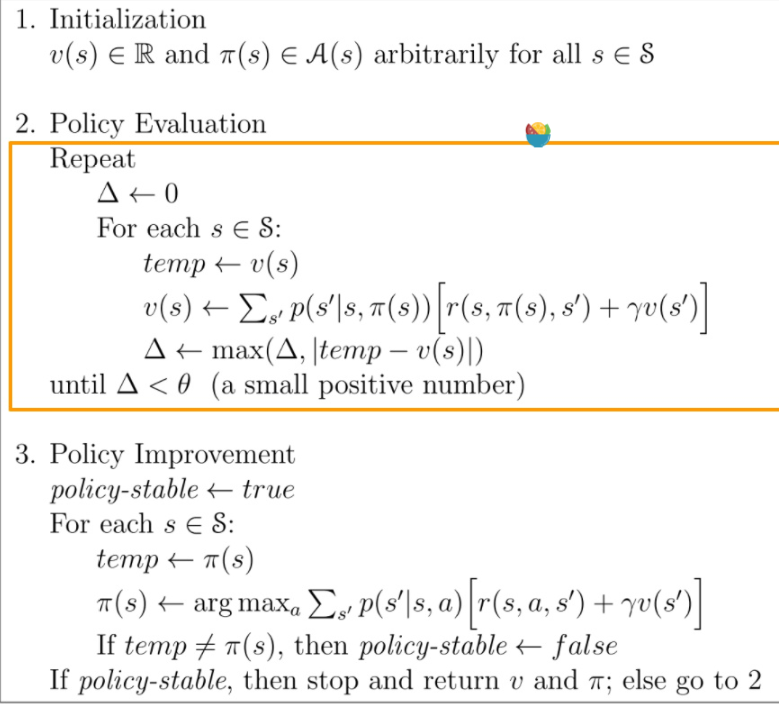

In [6]:
def optimize():
    # 策略评估
    res = policy_evaluate(0.0001)
    policy_before = {}
    while True:
        # 策略迭代
        policy = {}
        for s in res:
            max_score = -1
            max_action = ["a"]
            for action in ["a","s","w","d"]:                
                observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
                statis_dict = {}
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                        if action in statis_dict:
                            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                        else:
                            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
                for i in statis_dict:
                    if len(statis_dict[i]) > 1:
                        if np.average(statis_dict[i]) > max_score:
                            max_score = np.average(statis_dict[i])
                            max_action = [i]
                policy[s] = max_action
        # 策略评估
        res = policy_evaluate(0.0001,res,policy)
        
        # 策略不变时退出
        if policy == policy_before:
            break
        
        policy_before = copy.deepcopy(policy)
    return policy,res

In [7]:
policy,res = optimize()

use old
use old
use old


In [24]:
policy

{'(8, 8, 2, 16)': ['d'],
 '(0, 8, 2, 0)': ['a'],
 '(2, 16, 0, 4)': ['s'],
 '(32, 4, 4, 2)': ['a'],
 '(0, 2, 16, 0)': ['a'],
 '(2, 2, 2, 16)': ['s'],
 '(8, 8, 8, 16)': ['s'],
 '(0, 32, 8, 8)': ['a'],
 '(8, 4, 0, 32)': ['a'],
 '(8, 8, 2, 0)': ['a'],
 '(0, 4, 4, 0)': ['a'],
 '(2, 4, 2, 8)': ['w'],
 '(16, 2, 16, 4)': ['s'],
 '(2, 2, 0, 0)': ['s'],
 '(32, 8, 4, 16)': ['a'],
 '(2, 8, 2, 2)': ['w'],
 '(16, 16, 2, 32)': ['a'],
 '(8, 32, 0, 2)': ['a'],
 '(32, 4, 8, 16)': ['a'],
 '(0, 16, 4, 4)': ['a'],
 '(2, 8, 4, 4)': ['d'],
 '(8, 8, 0, 4)': ['a'],
 '(8, 8, 2, 4)': ['d'],
 '(2, 0, 4, 4)': ['a'],
 '(8, 32, 2, 8)': ['a'],
 '(0, 16, 32, 8)': ['a'],
 '(2, 2, 0, 8)': ['a'],
 '(16, 32, 0, 2)': ['a'],
 '(32, 2, 2, 16)': ['a'],
 '(4, 4, 8, 16)': ['a'],
 '(2, 8, 0, 2)': ['a'],
 '(2, 16, 16, 16)': ['s'],
 '(4, 0, 2, 2)': ['a'],
 '(2, 32, 8, 4)': ['a'],
 '(8, 32, 16, 0)': ['s'],
 '(0, 0, 32, 16)': ['w'],
 '(0, 8, 8, 16)': ['a'],
 '(8, 0, 4, 0)': ['d'],
 '(16, 32, 4, 8)': ['a'],
 '(0, 4, 32, 0)': ['a'],
 

In [9]:
# 策略迭代测试
def check_one_game_with_policy(gameEnv,policy,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = policy[str(tuple(np.array(observation).reshape(-1).tolist()))][0]
        if debug:print "choose:",action
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score
def evaluate(gameEnv,policy):
    scores = []
    n = 10000
    for i in range(n):
        scores.append(check_one_game_with_policy(gameEnv,policy,False))
    print "avg:%d max:%d min:%d "%(np.average(scores),np.max(scores), np.min(scores))
    
evaluate(gameEnv,policy)

avg:58 max:168 min:12 


# 值迭代

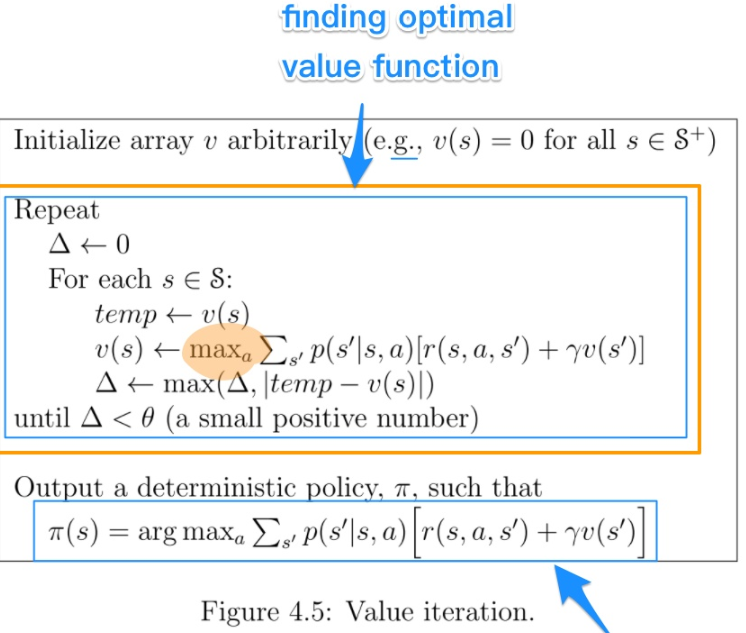

In [10]:
def value_iteration():
    hold = 0.000001
    # 初始化所有状态，包含了部分不存在的状态
    v_dict = {}
    for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
        v_dict[str(s)] = 0
    s_list = v_dict.keys()
    
    while True:
        delta = 0
        for s in s_list:
            temp = v_dict[s]
            # find max_a v
            max_score = 0
            max_action = ["a"]
            for action in ["a","s","w","d"]:                
                observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
                statis_dict = {}
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                        if action in statis_dict:
                            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                        else:
                            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
                for i in statis_dict:
                    if len(statis_dict[i]) > 1:
                        if np.average(statis_dict[i]) > max_score:
                            max_score = np.average(statis_dict[i])
                            max_action = [i]
            vs = max_score
            v_dict[s] = vs
            delta = max(delta,abs(temp - vs))
        if delta < hold:
            break
    return v_dict

def get_policy(res):
     # 策略迭代
    policy = {}
    for s in res:
        max_score = -2
        max_action = ["a"]
        for action in ["a","s","w","d"]:                
            observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
            statis_dict = {}
            for i in range(len(observation_next_list)):
                if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                    if action in statis_dict:
                        statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                    else:
                        statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
            for i in statis_dict:
                if len(statis_dict[i]) > 1:
                    if np.average(statis_dict[i]) > max_score:
                        max_score = np.average(statis_dict[i])
                        max_action = [i]
            policy[s] = max_action
    return policy

In [11]:
res = value_iteration()

In [12]:
policy = get_policy(res)

In [19]:
status = str((2,2,0,0))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i]),statis_dict[i]
print policy[status]

2	 2	 

-	 -	 

a 54.33921464284261 [53.516592025756836, 54.94322967529297, 53.93233299255371, 54.76757049560547, 53.93233299255371, 54.94322967529297]
s 54.34995174407959 [53.93233299255371, 54.76757049560547, 53.93233299255371, 54.76757049560547]
w 58.34995174407959 [58.34995174407959]
d 54.28041744232178 [53.894765853881836, 54.94322967529297, 53.93233299255371, 54.94322967529297, 53.93233299255371, 54.03661346435547]
['s']


In [ ]:
evaluate(gameEnv,policy)

avg:59 max:172 min:12 
